# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    num_workers = 0

    data_transforms=transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])  #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

    data_data=datasets.ImageFolder(data_dir, transform=data_transforms)

    DataLoader=torch.utils.data.DataLoader(data_data, batch_size, shuffle=True, num_workers=num_workers)
      
    return DataLoader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

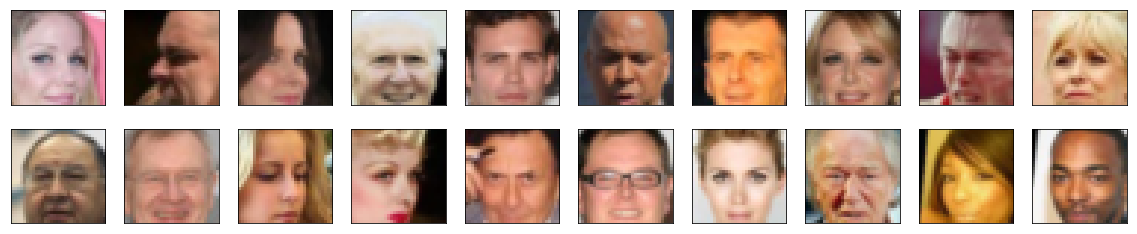

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min,max=feature_range
    x = x * (max - min) + min
   
    return x

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.6471)
Max:  tensor(0.9686)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

#helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    # Create conv layers with optional batch normalization
    
    layers=[]
    conv_layer=nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    
    # Append conv layers
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    # using sequential container
    return nn.Sequential(*layers)
        

In [9]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim=conv_dim
        # 32x32 input
        self.conv1=conv(3, conv_dim, 4, batch_norm=False)
        # 16x16 out
        self.conv2=conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3=conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        #flatten
        self.fc=nn.Linear(conv_dim*4*4*4,1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        out=F.leaky_relu(self.conv1(x), 0.2)
        out=F.leaky_relu(self.conv2(out), 0.2)
        out=F.leaky_relu(self.conv3(out), 0.2)
        
        #flatten
        out=out.view(-1, self.conv_dim*4*4*4)
        
        #final output layer
        out=self.fc(out)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [10]:
#helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    # Create conv layers with optional batch normalization
    
    layers=[]
    transpose_conv_layer=nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    
    # Append conv layers
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    # using sequential container
    return nn.Sequential(*layers)

In [11]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim=conv_dim
        
        #first fully connected layer
        self.fc=nn.Linear(z_size, conv_dim*4*4*4)
        
        # transpose conv layers
        self.t_conv1=deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2=deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3=deconv(conv_dim, 3, 4, batch_norm=False)
         

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # fully-connected + reshape
        out=self.fc(x)
        out=out.view(-1, self.conv_dim*4, 4, 4)
        
        # hidden transpose conv layers + relu
        out=F.relu(self.t_conv1(out))
        out=F.relu(self.t_conv2(out))
        
        out=self.t_conv3(out)
        out=F.tanh(out)
           
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

C:\Users\Sertan\Anaconda3\envs\dog\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [12]:
from torch.nn import init
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [14]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [16]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    loss = torch.mean((D_out-1)**2)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    loss = torch.mean(D_out**2)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [17]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.1
beta2=0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [18]:
import pickle as pkl
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            #d_loss = 

            d_optimizer.zero_grad()
        
            # 1. Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 2. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            
            
            # 2. Train the generator with an adversarial loss
            #g_loss = 
            
            g_optimizer.zero_grad()

            # 1. Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        if train_on_gpu:
            fixed_z = fixed_z.cuda()
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [19]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 2.0394 | g_loss: 1.0041
Epoch [    1/   50] | d_loss: 0.2345 | g_loss: 0.5742
Epoch [    1/   50] | d_loss: 0.0866 | g_loss: 1.0438
Epoch [    1/   50] | d_loss: 0.1620 | g_loss: 1.0303
Epoch [    1/   50] | d_loss: 0.1813 | g_loss: 1.2150
Epoch [    1/   50] | d_loss: 0.1335 | g_loss: 0.7841
Epoch [    1/   50] | d_loss: 0.1609 | g_loss: 0.4962
Epoch [    1/   50] | d_loss: 0.5554 | g_loss: 0.1783
Epoch [    1/   50] | d_loss: 0.2689 | g_loss: 1.1241
Epoch [    1/   50] | d_loss: 0.4829 | g_loss: 1.1601
Epoch [    1/   50] | d_loss: 0.0967 | g_loss: 0.7039
Epoch [    1/   50] | d_loss: 0.1926 | g_loss: 0.6079
Epoch [    1/   50] | d_loss: 0.9320 | g_loss: 0.0690
Epoch [    1/   50] | d_loss: 0.2053 | g_loss: 0.5367
Epoch [    1/   50] | d_loss: 0.2403 | g_loss: 1.1023
Epoch [    1/   50] | d_loss: 0.2094 | g_loss: 0.4504
Epoch [    1/   50] | d_loss: 0.2219 | g_loss: 0.4430
Epoch [    1/   50] | d_loss: 0.3780 | g_loss: 1.0327
Epoch [    1/   50] | d_loss

Epoch [    3/   50] | d_loss: 0.4779 | g_loss: 0.3259
Epoch [    3/   50] | d_loss: 0.3325 | g_loss: 0.5671
Epoch [    3/   50] | d_loss: 0.2636 | g_loss: 0.4151
Epoch [    3/   50] | d_loss: 0.2218 | g_loss: 0.4843
Epoch [    3/   50] | d_loss: 0.3462 | g_loss: 0.4363
Epoch [    3/   50] | d_loss: 0.4479 | g_loss: 0.2009
Epoch [    3/   50] | d_loss: 0.3166 | g_loss: 0.6866
Epoch [    3/   50] | d_loss: 0.1880 | g_loss: 0.5962
Epoch [    3/   50] | d_loss: 0.2140 | g_loss: 0.8273
Epoch [    3/   50] | d_loss: 0.2235 | g_loss: 0.8291
Epoch [    3/   50] | d_loss: 0.3679 | g_loss: 0.3520
Epoch [    3/   50] | d_loss: 0.2312 | g_loss: 0.4318
Epoch [    3/   50] | d_loss: 0.3376 | g_loss: 0.4158
Epoch [    3/   50] | d_loss: 0.3459 | g_loss: 0.4409
Epoch [    3/   50] | d_loss: 0.7190 | g_loss: 0.0949
Epoch [    3/   50] | d_loss: 0.2743 | g_loss: 0.5055
Epoch [    3/   50] | d_loss: 0.3508 | g_loss: 0.3873
Epoch [    3/   50] | d_loss: 0.4045 | g_loss: 0.7532
Epoch [    3/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.1280 | g_loss: 0.6075
Epoch [    6/   50] | d_loss: 0.1926 | g_loss: 0.7090
Epoch [    6/   50] | d_loss: 0.2227 | g_loss: 0.4252
Epoch [    6/   50] | d_loss: 0.2908 | g_loss: 0.3700
Epoch [    6/   50] | d_loss: 0.2811 | g_loss: 0.3392
Epoch [    6/   50] | d_loss: 0.2032 | g_loss: 0.2489
Epoch [    6/   50] | d_loss: 0.1572 | g_loss: 1.0253
Epoch [    6/   50] | d_loss: 0.1824 | g_loss: 0.5840
Epoch [    6/   50] | d_loss: 0.2420 | g_loss: 0.7143
Epoch [    6/   50] | d_loss: 0.2158 | g_loss: 0.7633
Epoch [    6/   50] | d_loss: 0.3419 | g_loss: 0.8121
Epoch [    6/   50] | d_loss: 0.1970 | g_loss: 1.4949
Epoch [    6/   50] | d_loss: 0.2949 | g_loss: 0.6859
Epoch [    6/   50] | d_loss: 0.2996 | g_loss: 0.9823
Epoch [    6/   50] | d_loss: 0.3070 | g_loss: 0.6611
Epoch [    6/   50] | d_loss: 0.3613 | g_loss: 0.6379
Epoch [    6/   50] | d_loss: 0.5057 | g_loss: 0.2887
Epoch [    6/   50] | d_loss: 0.6559 | g_loss: 0.2678
Epoch [    6/   50] | d_loss

Epoch [    8/   50] | d_loss: 0.1563 | g_loss: 0.6678
Epoch [    8/   50] | d_loss: 0.1207 | g_loss: 0.6640
Epoch [    8/   50] | d_loss: 0.2728 | g_loss: 0.4226
Epoch [    9/   50] | d_loss: 0.3951 | g_loss: 0.2775
Epoch [    9/   50] | d_loss: 0.2115 | g_loss: 0.4367
Epoch [    9/   50] | d_loss: 0.1558 | g_loss: 0.3877
Epoch [    9/   50] | d_loss: 0.1739 | g_loss: 0.6307
Epoch [    9/   50] | d_loss: 0.3150 | g_loss: 0.3144
Epoch [    9/   50] | d_loss: 0.4059 | g_loss: 0.2542
Epoch [    9/   50] | d_loss: 0.1433 | g_loss: 0.6006
Epoch [    9/   50] | d_loss: 0.0878 | g_loss: 0.6820
Epoch [    9/   50] | d_loss: 0.1239 | g_loss: 0.5876
Epoch [    9/   50] | d_loss: 0.2441 | g_loss: 0.1696
Epoch [    9/   50] | d_loss: 0.2314 | g_loss: 0.3092
Epoch [    9/   50] | d_loss: 0.2723 | g_loss: 0.4637
Epoch [    9/   50] | d_loss: 0.2696 | g_loss: 0.6520
Epoch [    9/   50] | d_loss: 0.1497 | g_loss: 0.5724
Epoch [    9/   50] | d_loss: 0.1962 | g_loss: 0.7290
Epoch [    9/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.2077 | g_loss: 0.9481
Epoch [   11/   50] | d_loss: 0.2452 | g_loss: 0.8644
Epoch [   11/   50] | d_loss: 0.1983 | g_loss: 0.6125
Epoch [   11/   50] | d_loss: 0.2490 | g_loss: 0.3094
Epoch [   11/   50] | d_loss: 0.4262 | g_loss: 0.6034
Epoch [   11/   50] | d_loss: 0.1570 | g_loss: 0.8951
Epoch [   11/   50] | d_loss: 0.3158 | g_loss: 0.3557
Epoch [   11/   50] | d_loss: 0.1124 | g_loss: 0.5106
Epoch [   11/   50] | d_loss: 0.1474 | g_loss: 0.5973
Epoch [   11/   50] | d_loss: 0.1771 | g_loss: 0.8366
Epoch [   11/   50] | d_loss: 0.1885 | g_loss: 0.6386
Epoch [   11/   50] | d_loss: 0.2519 | g_loss: 0.6524
Epoch [   11/   50] | d_loss: 0.6138 | g_loss: 1.6497
Epoch [   11/   50] | d_loss: 0.1749 | g_loss: 0.7586
Epoch [   11/   50] | d_loss: 0.3214 | g_loss: 0.9440
Epoch [   11/   50] | d_loss: 0.1483 | g_loss: 0.8684
Epoch [   11/   50] | d_loss: 0.1985 | g_loss: 0.7087
Epoch [   11/   50] | d_loss: 0.2815 | g_loss: 0.9010
Epoch [   11/   50] | d_loss

Epoch [   14/   50] | d_loss: 0.3492 | g_loss: 0.4629
Epoch [   14/   50] | d_loss: 0.2204 | g_loss: 0.8985
Epoch [   14/   50] | d_loss: 0.3545 | g_loss: 0.4210
Epoch [   14/   50] | d_loss: 0.1533 | g_loss: 0.9026
Epoch [   14/   50] | d_loss: 0.2884 | g_loss: 0.3214
Epoch [   14/   50] | d_loss: 0.1930 | g_loss: 0.7561
Epoch [   14/   50] | d_loss: 0.2103 | g_loss: 0.9341
Epoch [   14/   50] | d_loss: 0.1263 | g_loss: 0.4563
Epoch [   14/   50] | d_loss: 0.1843 | g_loss: 0.5889
Epoch [   14/   50] | d_loss: 0.1502 | g_loss: 0.6190
Epoch [   14/   50] | d_loss: 0.1089 | g_loss: 0.8552
Epoch [   14/   50] | d_loss: 0.1273 | g_loss: 0.9834
Epoch [   14/   50] | d_loss: 0.1034 | g_loss: 0.7363
Epoch [   14/   50] | d_loss: 0.0880 | g_loss: 0.8570
Epoch [   14/   50] | d_loss: 0.2019 | g_loss: 0.6228
Epoch [   14/   50] | d_loss: 0.1386 | g_loss: 0.3779
Epoch [   14/   50] | d_loss: 0.4221 | g_loss: 0.2126
Epoch [   14/   50] | d_loss: 0.1892 | g_loss: 0.7037
Epoch [   14/   50] | d_loss

Epoch [   16/   50] | d_loss: 0.0757 | g_loss: 0.7863
Epoch [   16/   50] | d_loss: 0.1245 | g_loss: 0.5657
Epoch [   16/   50] | d_loss: 0.2339 | g_loss: 1.2103
Epoch [   16/   50] | d_loss: 0.2563 | g_loss: 0.6547
Epoch [   16/   50] | d_loss: 0.2048 | g_loss: 1.1625
Epoch [   16/   50] | d_loss: 0.9977 | g_loss: 0.0490
Epoch [   17/   50] | d_loss: 0.2685 | g_loss: 0.8692
Epoch [   17/   50] | d_loss: 0.0940 | g_loss: 0.8724
Epoch [   17/   50] | d_loss: 0.2330 | g_loss: 0.5627
Epoch [   17/   50] | d_loss: 0.2019 | g_loss: 0.6241
Epoch [   17/   50] | d_loss: 0.1040 | g_loss: 0.7086
Epoch [   17/   50] | d_loss: 0.1393 | g_loss: 0.6859
Epoch [   17/   50] | d_loss: 0.1939 | g_loss: 0.4498
Epoch [   17/   50] | d_loss: 0.1397 | g_loss: 0.7932
Epoch [   17/   50] | d_loss: 0.2477 | g_loss: 0.9868
Epoch [   17/   50] | d_loss: 0.3917 | g_loss: 1.1549
Epoch [   17/   50] | d_loss: 0.2516 | g_loss: 0.9694
Epoch [   17/   50] | d_loss: 0.0603 | g_loss: 0.9053
Epoch [   17/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.1801 | g_loss: 0.6241
Epoch [   19/   50] | d_loss: 0.1028 | g_loss: 0.9537
Epoch [   19/   50] | d_loss: 0.2555 | g_loss: 1.1051
Epoch [   19/   50] | d_loss: 0.1759 | g_loss: 0.7130
Epoch [   19/   50] | d_loss: 0.1939 | g_loss: 0.9157
Epoch [   19/   50] | d_loss: 0.1032 | g_loss: 0.9922
Epoch [   19/   50] | d_loss: 0.2343 | g_loss: 0.8788
Epoch [   19/   50] | d_loss: 0.1086 | g_loss: 0.6588
Epoch [   19/   50] | d_loss: 0.1798 | g_loss: 0.4279
Epoch [   19/   50] | d_loss: 0.1330 | g_loss: 0.9444
Epoch [   19/   50] | d_loss: 0.4005 | g_loss: 0.1389
Epoch [   19/   50] | d_loss: 0.3458 | g_loss: 0.2865
Epoch [   19/   50] | d_loss: 0.3419 | g_loss: 0.2691
Epoch [   19/   50] | d_loss: 0.0995 | g_loss: 0.6587
Epoch [   19/   50] | d_loss: 0.1645 | g_loss: 0.7329
Epoch [   19/   50] | d_loss: 0.2099 | g_loss: 0.8363
Epoch [   19/   50] | d_loss: 0.1358 | g_loss: 0.6389
Epoch [   19/   50] | d_loss: 0.1641 | g_loss: 0.6118
Epoch [   19/   50] | d_loss

Epoch [   22/   50] | d_loss: 0.1790 | g_loss: 0.4521
Epoch [   22/   50] | d_loss: 0.0720 | g_loss: 0.8568
Epoch [   22/   50] | d_loss: 0.1553 | g_loss: 1.5750
Epoch [   22/   50] | d_loss: 0.1047 | g_loss: 0.9637
Epoch [   22/   50] | d_loss: 0.1058 | g_loss: 0.8486
Epoch [   22/   50] | d_loss: 0.1097 | g_loss: 0.8382
Epoch [   22/   50] | d_loss: 0.1089 | g_loss: 0.8580
Epoch [   22/   50] | d_loss: 0.8226 | g_loss: 1.6748
Epoch [   22/   50] | d_loss: 0.1794 | g_loss: 0.9482
Epoch [   22/   50] | d_loss: 0.1075 | g_loss: 0.8821
Epoch [   22/   50] | d_loss: 0.0966 | g_loss: 0.8377
Epoch [   22/   50] | d_loss: 0.4127 | g_loss: 0.9204
Epoch [   22/   50] | d_loss: 0.1189 | g_loss: 0.3676
Epoch [   22/   50] | d_loss: 0.1301 | g_loss: 0.7590
Epoch [   22/   50] | d_loss: 0.1336 | g_loss: 0.7096
Epoch [   22/   50] | d_loss: 0.0933 | g_loss: 0.8153
Epoch [   22/   50] | d_loss: 0.1090 | g_loss: 0.7400
Epoch [   22/   50] | d_loss: 0.0672 | g_loss: 0.8631
Epoch [   22/   50] | d_loss

Epoch [   24/   50] | d_loss: 0.1093 | g_loss: 0.7313
Epoch [   24/   50] | d_loss: 0.0926 | g_loss: 0.9492
Epoch [   24/   50] | d_loss: 0.1918 | g_loss: 0.7934
Epoch [   24/   50] | d_loss: 0.3758 | g_loss: 0.3681
Epoch [   24/   50] | d_loss: 0.1803 | g_loss: 0.6307
Epoch [   24/   50] | d_loss: 0.0808 | g_loss: 0.8280
Epoch [   24/   50] | d_loss: 0.2080 | g_loss: 0.8150
Epoch [   24/   50] | d_loss: 0.0944 | g_loss: 0.7597
Epoch [   24/   50] | d_loss: 0.1275 | g_loss: 0.4328
Epoch [   25/   50] | d_loss: 0.0642 | g_loss: 0.7032
Epoch [   25/   50] | d_loss: 0.1903 | g_loss: 0.5570
Epoch [   25/   50] | d_loss: 0.2993 | g_loss: 1.4034
Epoch [   25/   50] | d_loss: 0.0541 | g_loss: 0.9318
Epoch [   25/   50] | d_loss: 0.1400 | g_loss: 0.4413
Epoch [   25/   50] | d_loss: 0.2269 | g_loss: 1.0745
Epoch [   25/   50] | d_loss: 0.2911 | g_loss: 0.3162
Epoch [   25/   50] | d_loss: 0.3206 | g_loss: 0.3656
Epoch [   25/   50] | d_loss: 0.0758 | g_loss: 0.7377
Epoch [   25/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.0913 | g_loss: 0.6748
Epoch [   27/   50] | d_loss: 0.0805 | g_loss: 0.9417
Epoch [   27/   50] | d_loss: 0.2845 | g_loss: 0.3658
Epoch [   27/   50] | d_loss: 0.1084 | g_loss: 0.7532
Epoch [   27/   50] | d_loss: 0.2056 | g_loss: 0.1406
Epoch [   27/   50] | d_loss: 0.1444 | g_loss: 0.7357
Epoch [   27/   50] | d_loss: 0.3102 | g_loss: 0.4908
Epoch [   27/   50] | d_loss: 0.0649 | g_loss: 0.5026
Epoch [   27/   50] | d_loss: 0.1583 | g_loss: 0.5430
Epoch [   27/   50] | d_loss: 0.1545 | g_loss: 1.0148
Epoch [   27/   50] | d_loss: 0.1806 | g_loss: 0.9517
Epoch [   27/   50] | d_loss: 0.1264 | g_loss: 1.2504
Epoch [   27/   50] | d_loss: 0.1056 | g_loss: 0.7064
Epoch [   27/   50] | d_loss: 0.2191 | g_loss: 1.2760
Epoch [   27/   50] | d_loss: 0.1289 | g_loss: 0.6886
Epoch [   27/   50] | d_loss: 0.1428 | g_loss: 0.7222
Epoch [   27/   50] | d_loss: 0.2087 | g_loss: 0.4457
Epoch [   27/   50] | d_loss: 0.0662 | g_loss: 0.5594
Epoch [   27/   50] | d_loss

Epoch [   30/   50] | d_loss: 0.1364 | g_loss: 0.9805
Epoch [   30/   50] | d_loss: 0.3047 | g_loss: 0.2635
Epoch [   30/   50] | d_loss: 0.1022 | g_loss: 0.7701
Epoch [   30/   50] | d_loss: 0.1044 | g_loss: 0.8445
Epoch [   30/   50] | d_loss: 0.1573 | g_loss: 0.7070
Epoch [   30/   50] | d_loss: 0.2839 | g_loss: 1.3029
Epoch [   30/   50] | d_loss: 0.2423 | g_loss: 0.3611
Epoch [   30/   50] | d_loss: 0.3635 | g_loss: 0.4174
Epoch [   30/   50] | d_loss: 0.0420 | g_loss: 0.7911
Epoch [   30/   50] | d_loss: 0.0838 | g_loss: 0.5643
Epoch [   30/   50] | d_loss: 0.1380 | g_loss: 1.1478
Epoch [   30/   50] | d_loss: 0.1039 | g_loss: 0.9354
Epoch [   30/   50] | d_loss: 0.2095 | g_loss: 0.8285
Epoch [   30/   50] | d_loss: 0.0850 | g_loss: 0.9811
Epoch [   30/   50] | d_loss: 0.1014 | g_loss: 1.1697
Epoch [   30/   50] | d_loss: 0.0996 | g_loss: 0.6581
Epoch [   30/   50] | d_loss: 0.1058 | g_loss: 0.8317
Epoch [   30/   50] | d_loss: 0.1688 | g_loss: 1.0094
Epoch [   30/   50] | d_loss

Epoch [   32/   50] | d_loss: 0.0733 | g_loss: 0.5177
Epoch [   32/   50] | d_loss: 0.0983 | g_loss: 0.7287
Epoch [   32/   50] | d_loss: 0.0535 | g_loss: 1.2461
Epoch [   32/   50] | d_loss: 0.0735 | g_loss: 1.1574
Epoch [   32/   50] | d_loss: 0.1707 | g_loss: 0.5420
Epoch [   32/   50] | d_loss: 0.1856 | g_loss: 0.9900
Epoch [   32/   50] | d_loss: 0.1190 | g_loss: 1.2663
Epoch [   32/   50] | d_loss: 0.1823 | g_loss: 0.5039
Epoch [   32/   50] | d_loss: 0.1419 | g_loss: 0.9738
Epoch [   32/   50] | d_loss: 0.0751 | g_loss: 0.6637
Epoch [   32/   50] | d_loss: 0.1082 | g_loss: 0.7367
Epoch [   32/   50] | d_loss: 0.1804 | g_loss: 1.0062
Epoch [   33/   50] | d_loss: 0.1507 | g_loss: 0.6237
Epoch [   33/   50] | d_loss: 0.1650 | g_loss: 0.8808
Epoch [   33/   50] | d_loss: 0.2554 | g_loss: 1.3182
Epoch [   33/   50] | d_loss: 0.1487 | g_loss: 0.9352
Epoch [   33/   50] | d_loss: 0.1649 | g_loss: 0.5354
Epoch [   33/   50] | d_loss: 0.1868 | g_loss: 0.8454
Epoch [   33/   50] | d_loss

Epoch [   35/   50] | d_loss: 0.1741 | g_loss: 0.8865
Epoch [   35/   50] | d_loss: 0.0782 | g_loss: 0.7815
Epoch [   35/   50] | d_loss: 0.0491 | g_loss: 1.0712
Epoch [   35/   50] | d_loss: 0.1685 | g_loss: 0.7520
Epoch [   35/   50] | d_loss: 0.3406 | g_loss: 1.0427
Epoch [   35/   50] | d_loss: 0.1164 | g_loss: 1.2190
Epoch [   35/   50] | d_loss: 0.1590 | g_loss: 0.4912
Epoch [   35/   50] | d_loss: 0.0582 | g_loss: 0.9089
Epoch [   35/   50] | d_loss: 0.1412 | g_loss: 1.1880
Epoch [   35/   50] | d_loss: 0.0711 | g_loss: 0.9263
Epoch [   35/   50] | d_loss: 0.0715 | g_loss: 0.9026
Epoch [   35/   50] | d_loss: 0.0639 | g_loss: 1.1681
Epoch [   35/   50] | d_loss: 0.1325 | g_loss: 0.7272
Epoch [   35/   50] | d_loss: 0.0863 | g_loss: 1.2381
Epoch [   35/   50] | d_loss: 0.0941 | g_loss: 0.7842
Epoch [   35/   50] | d_loss: 0.1329 | g_loss: 0.9477
Epoch [   35/   50] | d_loss: 0.1130 | g_loss: 0.7111
Epoch [   35/   50] | d_loss: 0.1872 | g_loss: 0.7332
Epoch [   35/   50] | d_loss

Epoch [   38/   50] | d_loss: 0.1047 | g_loss: 0.8783
Epoch [   38/   50] | d_loss: 0.1197 | g_loss: 0.8249
Epoch [   38/   50] | d_loss: 0.0592 | g_loss: 0.8562
Epoch [   38/   50] | d_loss: 0.1116 | g_loss: 0.8132
Epoch [   38/   50] | d_loss: 0.0879 | g_loss: 1.1922
Epoch [   38/   50] | d_loss: 0.0877 | g_loss: 1.2181
Epoch [   38/   50] | d_loss: 0.0956 | g_loss: 0.5007
Epoch [   38/   50] | d_loss: 0.1343 | g_loss: 1.1109
Epoch [   38/   50] | d_loss: 0.0844 | g_loss: 0.5364
Epoch [   38/   50] | d_loss: 0.1274 | g_loss: 1.0648
Epoch [   38/   50] | d_loss: 0.1082 | g_loss: 0.7260
Epoch [   38/   50] | d_loss: 0.3269 | g_loss: 0.4273
Epoch [   38/   50] | d_loss: 0.1083 | g_loss: 1.0215
Epoch [   38/   50] | d_loss: 0.2063 | g_loss: 0.5044
Epoch [   38/   50] | d_loss: 0.1662 | g_loss: 0.8934
Epoch [   38/   50] | d_loss: 0.1424 | g_loss: 0.4744
Epoch [   38/   50] | d_loss: 0.1387 | g_loss: 0.9237
Epoch [   38/   50] | d_loss: 0.1097 | g_loss: 0.7261
Epoch [   38/   50] | d_loss

Epoch [   40/   50] | d_loss: 0.0768 | g_loss: 1.0971
Epoch [   40/   50] | d_loss: 0.1109 | g_loss: 0.5629
Epoch [   40/   50] | d_loss: 0.0864 | g_loss: 0.8059
Epoch [   40/   50] | d_loss: 0.0719 | g_loss: 0.9620
Epoch [   40/   50] | d_loss: 0.0642 | g_loss: 0.9822
Epoch [   40/   50] | d_loss: 0.2056 | g_loss: 0.9998
Epoch [   40/   50] | d_loss: 0.1288 | g_loss: 0.9513
Epoch [   40/   50] | d_loss: 0.1108 | g_loss: 0.9315
Epoch [   40/   50] | d_loss: 0.0982 | g_loss: 0.6984
Epoch [   40/   50] | d_loss: 0.0870 | g_loss: 0.8955
Epoch [   40/   50] | d_loss: 0.0540 | g_loss: 0.9316
Epoch [   40/   50] | d_loss: 0.0666 | g_loss: 1.2967
Epoch [   40/   50] | d_loss: 0.1377 | g_loss: 0.5780
Epoch [   40/   50] | d_loss: 0.2027 | g_loss: 0.8989
Epoch [   40/   50] | d_loss: 0.2363 | g_loss: 0.7049
Epoch [   41/   50] | d_loss: 0.1484 | g_loss: 0.9229
Epoch [   41/   50] | d_loss: 0.0517 | g_loss: 0.9115
Epoch [   41/   50] | d_loss: 0.1476 | g_loss: 0.7996
Epoch [   41/   50] | d_loss

Epoch [   43/   50] | d_loss: 0.1566 | g_loss: 0.6022
Epoch [   43/   50] | d_loss: 0.1133 | g_loss: 1.0121
Epoch [   43/   50] | d_loss: 0.0725 | g_loss: 0.7117
Epoch [   43/   50] | d_loss: 0.0622 | g_loss: 0.9132
Epoch [   43/   50] | d_loss: 0.0885 | g_loss: 1.2465
Epoch [   43/   50] | d_loss: 0.0928 | g_loss: 0.9528
Epoch [   43/   50] | d_loss: 0.0805 | g_loss: 0.9321
Epoch [   43/   50] | d_loss: 0.0630 | g_loss: 0.8316
Epoch [   43/   50] | d_loss: 0.0887 | g_loss: 0.9107
Epoch [   43/   50] | d_loss: 0.0855 | g_loss: 0.8943
Epoch [   43/   50] | d_loss: 0.0755 | g_loss: 1.0122
Epoch [   43/   50] | d_loss: 0.1951 | g_loss: 1.1467
Epoch [   43/   50] | d_loss: 0.1878 | g_loss: 0.4805
Epoch [   43/   50] | d_loss: 0.0522 | g_loss: 0.9472
Epoch [   43/   50] | d_loss: 0.0566 | g_loss: 0.8445
Epoch [   43/   50] | d_loss: 0.0679 | g_loss: 0.8834
Epoch [   43/   50] | d_loss: 0.2436 | g_loss: 0.7881
Epoch [   43/   50] | d_loss: 0.1444 | g_loss: 0.7942
Epoch [   43/   50] | d_loss

Epoch [   46/   50] | d_loss: 0.1440 | g_loss: 0.7804
Epoch [   46/   50] | d_loss: 0.0312 | g_loss: 0.7106
Epoch [   46/   50] | d_loss: 0.2434 | g_loss: 0.5418
Epoch [   46/   50] | d_loss: 0.0980 | g_loss: 0.6215
Epoch [   46/   50] | d_loss: 0.0396 | g_loss: 0.9392
Epoch [   46/   50] | d_loss: 0.0650 | g_loss: 1.0207
Epoch [   46/   50] | d_loss: 0.0877 | g_loss: 1.1408
Epoch [   46/   50] | d_loss: 0.1225 | g_loss: 0.9893
Epoch [   46/   50] | d_loss: 0.1374 | g_loss: 0.5293
Epoch [   46/   50] | d_loss: 0.0949 | g_loss: 0.7703
Epoch [   46/   50] | d_loss: 0.0662 | g_loss: 0.8874
Epoch [   46/   50] | d_loss: 0.0891 | g_loss: 1.4098
Epoch [   46/   50] | d_loss: 0.1164 | g_loss: 0.8327
Epoch [   46/   50] | d_loss: 0.1882 | g_loss: 0.5999
Epoch [   46/   50] | d_loss: 0.1692 | g_loss: 0.5662
Epoch [   46/   50] | d_loss: 0.1220 | g_loss: 0.7626
Epoch [   46/   50] | d_loss: 0.0771 | g_loss: 0.7747
Epoch [   46/   50] | d_loss: 0.4056 | g_loss: 0.1957
Epoch [   46/   50] | d_loss

Epoch [   48/   50] | d_loss: 0.0365 | g_loss: 0.6965
Epoch [   48/   50] | d_loss: 0.0974 | g_loss: 0.7992
Epoch [   48/   50] | d_loss: 0.0761 | g_loss: 0.6897
Epoch [   48/   50] | d_loss: 0.0601 | g_loss: 1.5095
Epoch [   48/   50] | d_loss: 0.0737 | g_loss: 0.8718
Epoch [   48/   50] | d_loss: 0.1136 | g_loss: 0.7635
Epoch [   48/   50] | d_loss: 0.1006 | g_loss: 0.8274
Epoch [   48/   50] | d_loss: 0.1825 | g_loss: 0.9934
Epoch [   48/   50] | d_loss: 0.0586 | g_loss: 0.5217
Epoch [   48/   50] | d_loss: 0.1138 | g_loss: 0.7711
Epoch [   48/   50] | d_loss: 0.1879 | g_loss: 0.7741
Epoch [   48/   50] | d_loss: 0.0602 | g_loss: 0.9150
Epoch [   48/   50] | d_loss: 0.0894 | g_loss: 1.0256
Epoch [   48/   50] | d_loss: 0.0441 | g_loss: 0.7612
Epoch [   48/   50] | d_loss: 0.3640 | g_loss: 1.4792
Epoch [   48/   50] | d_loss: 0.1289 | g_loss: 0.7644
Epoch [   48/   50] | d_loss: 0.1297 | g_loss: 0.6502
Epoch [   48/   50] | d_loss: 0.0473 | g_loss: 0.6448
Epoch [   49/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

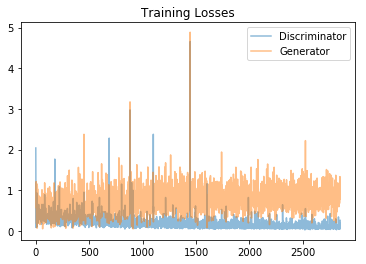

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [21]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [22]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

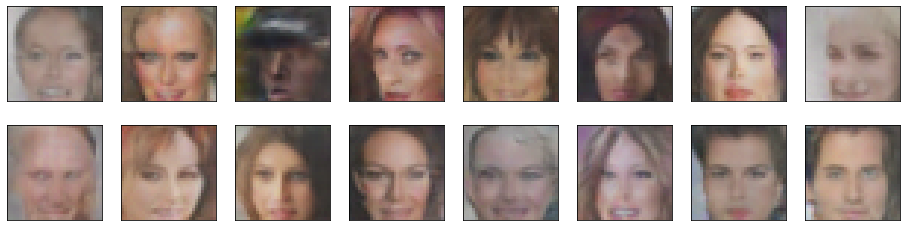

In [23]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** As indicated above, the data is biased. Therefore, we only see white people faces. Some of generated samples are so realistic. In general, we need to tweak the parameters by changing hyperparameters. Another drawback is that original image size is so small like 64x64. if we had 2000x2000 image size, the results would be definitely better. There are many rooms to optimize the accuracy such as number of epochs, batch size, number of layers, learning rate and so on.
Once I have changed the parameteres as indicated in the 1st submission, the face images become more realistic. 

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.